## Imports and Setup

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import string

In [2]:
from collections import Counter
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [3]:
from src.paths import INTERIM_CORPUS

In [4]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline

## Ingestion and Initial Inspection of the Data

### Number of files to collect

In [5]:
Counter(p.suffix for p in INTERIM_CORPUS.glob('*.csv'))

Counter({'.csv': 89})

### Import

In [6]:
df = pd.concat([
    pd.read_csv(
        f, 
        encoding='utf-8',
        parse_dates=['parsed_created_at'])
    for f in INTERIM_CORPUS.glob('*.csv')
], ignore_index=True)  # otherwise, index is weird

### Data Inspection

In [7]:
# first five rows
df.head()

,id,tweet_url,created_at,parsed_created_at,user_screen_name,text,tweet_type,coordinates,place,hashtags,...,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_statuses_count,user_time_zone,user_urls,user_verified
0,1088938753291362304,https://twitter.com/LloydCymru/status/10889387...,Fri Jan 25 23:16:44 +0000 2019,2019-01-25 23:16:44+00:00,LloydCymru,RT @AmphetCymru: Anytime a boomer Britnat who ...,retweet,NaN,NaN,NaN,...,9284,396,1215,0,"Aberystwyth, Cymru",Lloyd🏴󠁧󠁢󠁷󠁬󠁳󠁿,2597,NaN,NaN,False
1,1088938746530197504,https://twitter.com/KevinMitch76ell/status/108...,Fri Jan 25 23:16:43 +0000 2019,2019-01-25 23:16:43+00:00,KevinMitch76ell,RT @RebetikoWalrus: @hilarybennmp We don't wan...,retweet,NaN,NaN,Brexit,...,93585,472,444,3,"Esher, South East",Kevin Mitchell,57861,NaN,NaN,False
2,1088938744424599569,https://twitter.com/wisitwippl/status/10889387...,Fri Jan 25 23:16:42 +0000 2019,2019-01-25 23:16:42+00:00,wisitwippl,RT @uk_rants: Exactly the attitude one encount...,retweet,NaN,NaN,Brexit,...,8022,274,704,3,"Berkshire, UK",What Is It With People?,10870,NaN,NaN,False
3,1088938738099634181,https://twitter.com/MusedViews/status/10889387...,Fri Jan 25 23:16:41 +0000 2019,2019-01-25 23:16:41+00:00,MusedViews,RT @nickreeves9876: Tory ministers threaten vi...,retweet,NaN,NaN,NaN,...,425,678,1361,8,NaN,MusedViews #CancelBrexit,3167,NaN,NaN,False
4,1088938734752550913,https://twitter.com/HigherGroundPr2/status/108...,Fri Jan 25 23:16:40 +0000 2019,2019-01-25 23:16:40+00:00,HigherGroundPr2,RT @GETAnalysis: @MattCartoonist @Telegraph Re...,retweet,NaN,NaN,Britain Brexit Befuddlement,...,309,3,4,0,Waterfront Community,HigherGroundProductions,268,NaN,NaN,False


In [8]:
# last five rows
df.tail()

,id,tweet_url,created_at,parsed_created_at,user_screen_name,text,tweet_type,coordinates,place,hashtags,...,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_statuses_count,user_time_zone,user_urls,user_verified
285016,1089195480817512449,https://twitter.com/Rand0mB1tsUK/status/108919...,Sat Jan 26 16:16:53 +0000 2019,2019-01-26 16:16:53+00:00,Rand0mB1tsUK,"RT @CarolineLucas: #DearLeavers,\n\nYou were r...",retweet,NaN,NaN,DearLeavers,...,4002,2659,2908,42,UK,Random Bits 🔶 #FBPE #FinalSay,46012,NaN,NaN,False
285017,1089195478124769280,https://twitter.com/LScratchwood/status/108919...,Sat Jan 26 16:16:52 +0000 2019,2019-01-26 16:16:52+00:00,LScratchwood,RT @women4PV: Rosa has been running her flower...,retweet,NaN,NaN,Brexit,...,3060,74,141,0,"Dublin City, Ireland",Lieutenant Scratchwood,1896,NaN,NaN,False
285018,1089195464300277760,https://twitter.com/DougAlder/status/108919546...,Sat Jan 26 16:16:49 +0000 2019,2019-01-26 16:16:49+00:00,DougAlder,#Brexit #Caturday https://t.co/SHIi5SkjOc,original,NaN,NaN,Brexit Caturday,...,9631,992,2328,32,NaN,Just your average Maple Syrup bot,12283,NaN,NaN,False
285019,1089195461364408320,https://twitter.com/TraceF1/status/10891954613...,Sat Jan 26 16:16:48 +0000 2019,2019-01-26 16:16:48+00:00,TraceF1,RT @PrinceBraith9th: MB NEWS: Ann Widdecombe -...,retweet,NaN,NaN,NaN,...,11351,502,505,1,London,sunshine dayz 17.4M voted for No deal,3630,NaN,NaN,False
285020,1089195458252206080,https://twitter.com/IceColdCole/status/1089195...,Sat Jan 26 16:16:48 +0000 2019,2019-01-26 16:16:48+00:00,IceColdCole,RT @haynesdeborah: EXCLUSIVE: Armed forces hav...,retweet,NaN,NaN,NaN,...,3062,41,212,0,Stuck between VXH and WCP,Adam Cole,3093,NaN,NaN,False


**Variables/Column names**

In [9]:
df.columns

Index(['id', 'tweet_url', 'created_at', 'parsed_created_at',
       'user_screen_name', 'text', 'tweet_type', 'coordinates', 'place',
       'hashtags', 'media', 'urls', 'favorite_count',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'lang', 'possibly_sensitive', 'retweet_count',
       'retweet_or_quote_id', 'retweet_or_quote_screen_name',
       'retweet_or_quote_user_id', 'source', 'user_id', 'user_created_at',
       'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified'],
      dtype='object')

**Variable/Column types**

In [10]:
df.dtypes

id                                            int64
tweet_url                                    object
created_at                                   object
parsed_created_at               datetime64[ns, UTC]
user_screen_name                             object
text                                         object
tweet_type                                   object
coordinates                                  object
place                                        object
hashtags                                     object
media                                        object
urls                                         object
favorite_count                                int64
in_reply_to_screen_name                      object
in_reply_to_status_id                       float64
in_reply_to_user_id                         float64
lang                                         object
possibly_sensitive                           object
retweet_count                                 int64
retweet_or_q

## Basic Stats

In [11]:
df.shape

(285021, 37)

In [12]:
print(f'There are {df.shape[0]} rows (observations) and {df.shape[1]} columns (variables)')

There are 285021 rows (observations) and 37 columns (variables)


### Tweet Types

In [13]:
types = (df
         .tweet_type
         .value_counts()
        )
print(types)

retweet     208021
original     42805
reply        18494
quote        15701
Name: tweet_type, dtype: int64


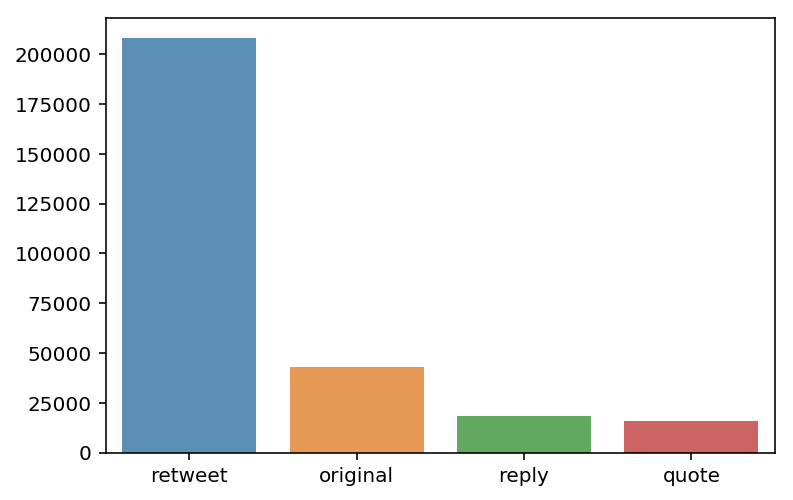

In [14]:
_ = sns.barplot(x=types.index, y=types.values, alpha=0.8)

### Tweet Types by Day

In [15]:
df.set_index('parsed_created_at', inplace=True)

In [16]:
df['day'] = df.index.date

In [17]:
daily_plot = df.groupby(['day', 'tweet_type']).size().unstack()

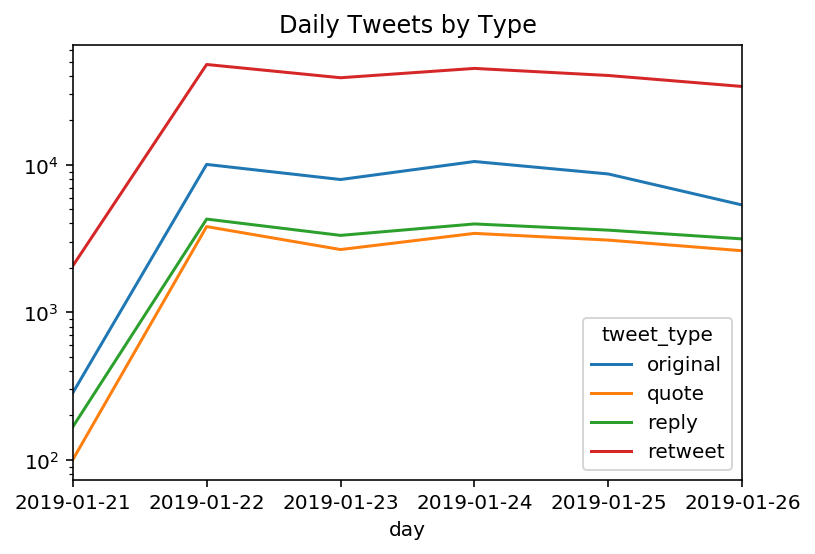

In [18]:
_ = daily_plot.plot(title='Daily Tweets by Type', logy=True)

Note that the y-axis is on the log scale. 

### Users

In [19]:
# number of unique tweeters
df['user_screen_name'].nunique()

111190

In [20]:
print(f"There are {df['user_screen_name'].nunique()} distinct users.")

There are 111190 distinct users.


In [21]:
tweeps = (df.groupby(['user_screen_name'])
         .count()
         .reset_index())

In [22]:
tweeps = (tweeps
         .sort_values(by='text')
         .tail(10))

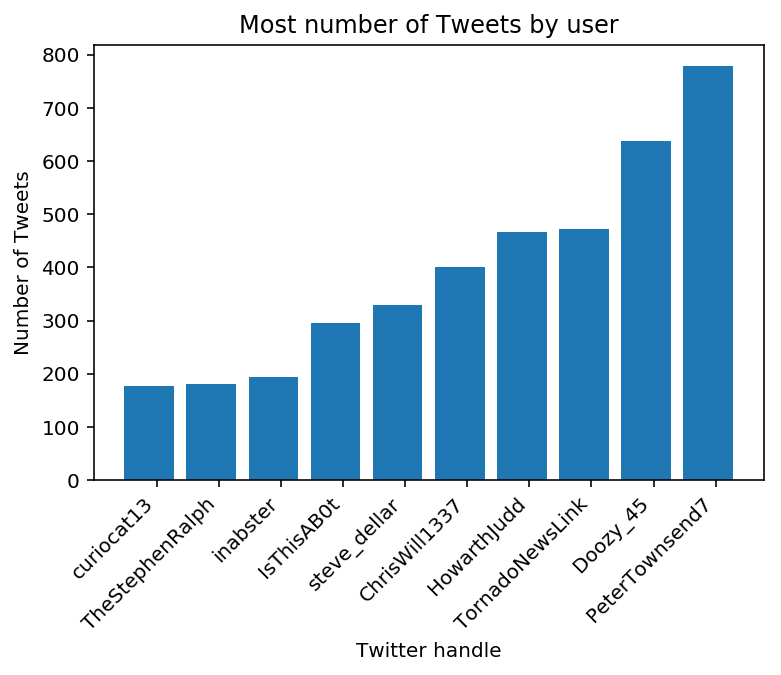

In [23]:
x = tweeps['user_screen_name']
y = tweeps['text']
plt.xlabel('Twitter handle')
plt.ylabel('Number of Tweets')
plt.title('Most number of Tweets by user')
h=plt.bar(range(10), y, label='Most Tweets by user')
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
_ = plt.xticks(xticks_pos, x, ha='right', rotation=45)

### Languages

In [24]:
df['lang'].nunique()

49

In [25]:
print(f"There are {df['lang'].nunique()} distinct languages (including undetermined ones)")

There are 49 distinct languages (including undetermined ones)


In [26]:
languages = (df
             .lang
             .value_counts())

languages.head(10)

en     259797
fr       5733
und      5162
de       4299
es       3103
it       2439
nl       1353
pl        716
fi        313
ca        292
Name: lang, dtype: int64

#### Undetermined languages

Let's take a look at languages that Twitter didn't classify

In [27]:
# create a mask for filtering
und = df['lang'] == 'und'

In [28]:
df[und]['text'].head(20)

parsed_created_at
2019-01-25 23:16:15+00:00       #Brexit ⁦@MarkHiggie1⁩ https://t.co/ggfsSSp8Lq
2019-01-25 23:15:27+00:00                      #Brexit https://t.co/qzi31LKvpk
2019-01-25 23:10:07+00:00    #Brexit #Scotland #Wales #England  #Northernir...
2019-01-25 23:09:57+00:00    #Brexit #Scotland #Wales #England  #Northernir...
2019-01-25 23:09:43+00:00    #Brexit #Scotland #Wales #England  #Northernir...
2019-01-25 23:09:34+00:00    #Brexit #Scotland #Wales #England  #Northernir...
2019-01-25 23:09:04+00:00    #Brexit #Scotland #Wales #England  #Northernir...
2019-01-25 23:08:52+00:00    #Brexit #Scotland #Wales #England  #Northernir...
2019-01-25 23:06:57+00:00    #Brexit #Scotland #Wales #England  #Northernir...
2019-01-25 23:06:47+00:00    #Brexit #Scotland #Wales #England  #Northernir...
2019-01-25 23:04:46+00:00    #Brexit #Scotland #Wales #England  #Northernir...
2019-01-25 23:04:35+00:00    #Brexit #Scotland #Wales #England  #Northernir...
2019-01-25 23:03:45+00:00    #Brex

Looks like these are tweets that consist only of hashtags, mentions, urls, etc. Should try to examine further. 

### Hashtags

We'll get the hashtags from the text to make sure we get all of them, as the `hashtag` field isn't always reliable. 

In [29]:
hashtags = (df
            .text
            .str.extractall(r'(\#\w+)')[0]
            .str.lower()
            .value_counts()
           )

In [30]:
hashtags.nunique()

278

In [31]:
hashtags = hashtags[1:11,]

In [32]:
hashtags

#peoplesvote     8870
#eu              6106
#conservative    3530
#lab             3447
#dyson           3288
#trump           2733
#uk              2692
#nodeal          2213
#bre             1990
#fbpe            1949
Name: 0, dtype: int64

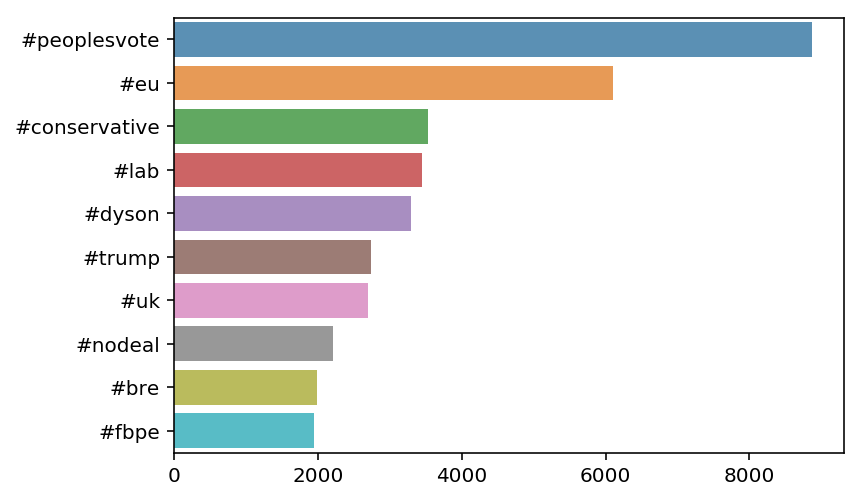

In [33]:
_ = sns.barplot(x=hashtags.values, y=hashtags.index, alpha=0.8)

### Mentions

In [34]:
mentions = (df
            .text
            .str.extractall(r'(@[\w_]+)')[0]
            .str.lower()
            .value_counts()
)

In [35]:
mentions = mentions[:10,]

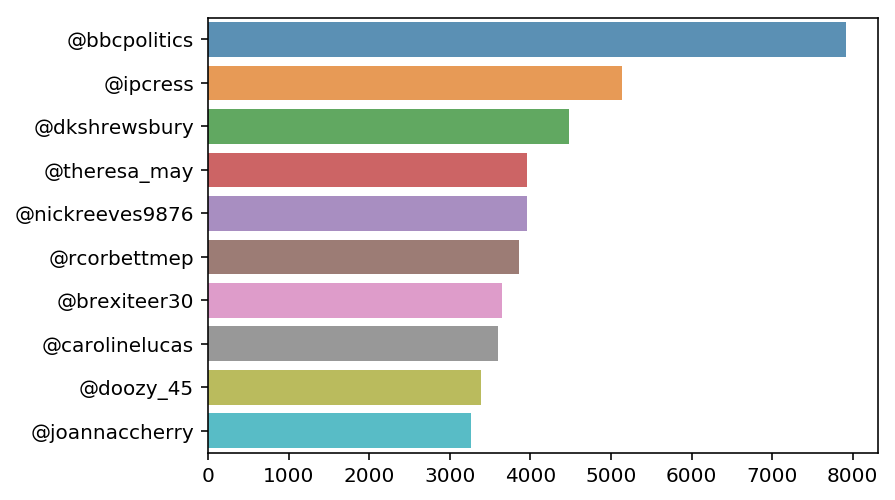

In [36]:
_ = sns.barplot(x=mentions.values, y=mentions.index, alpha=0.8)

### Wordcloud

I have my doubts about how informative wordclouds actually are, but maybe they work as art.

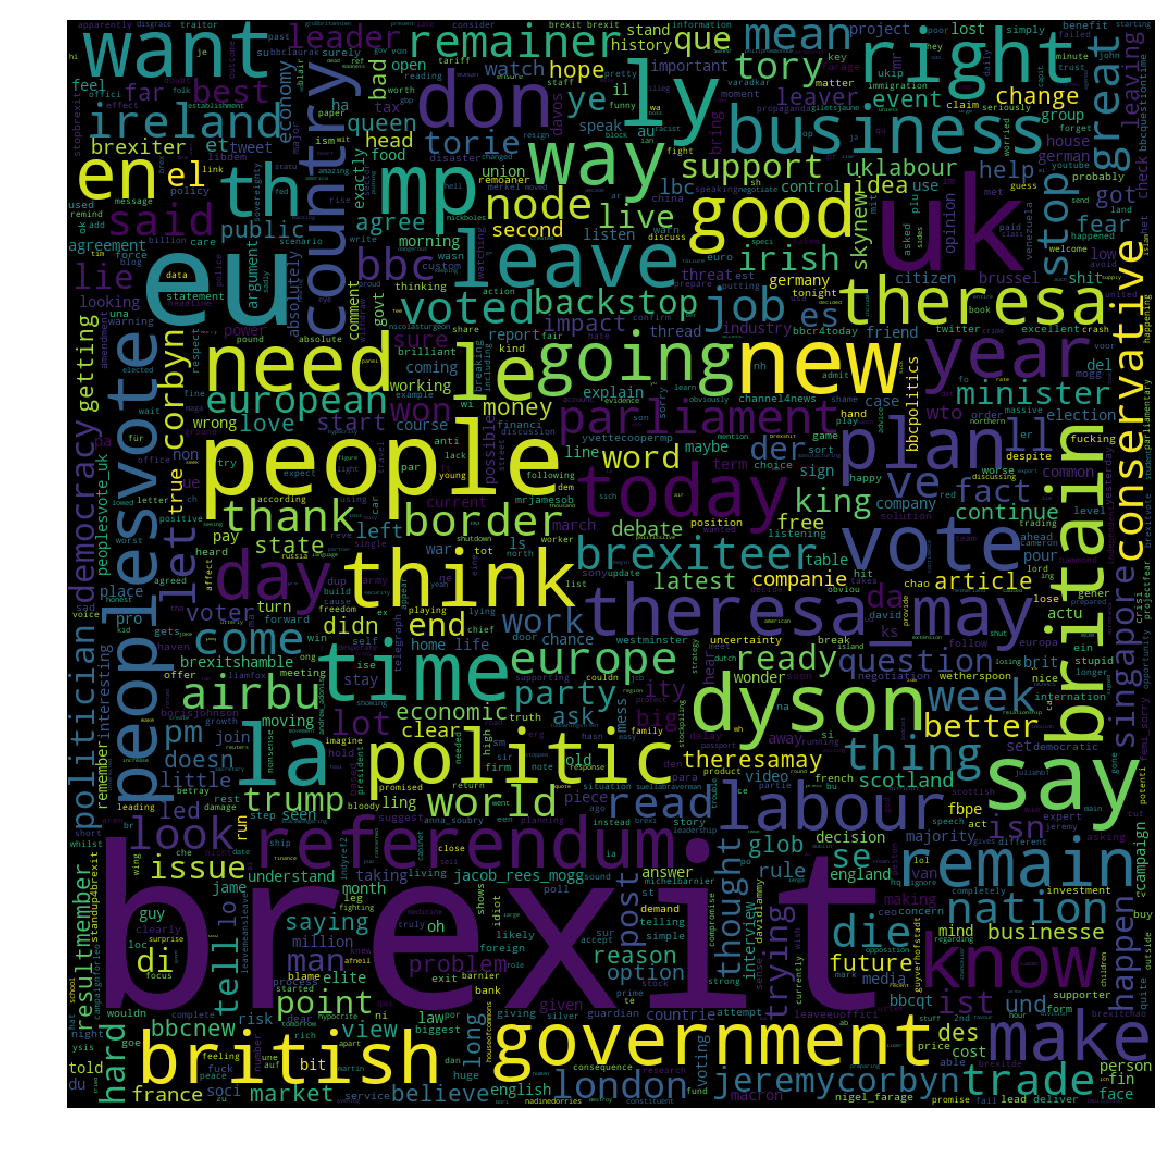

In [37]:
junk = re.compile("al|RT|\n|&.*?;|http[s](?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)*")
tweets = [junk.sub(" ", t) for t in df.text]

vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=.5)
tfv = vec.fit_transform(tweets)

terms = vec.get_feature_names()
wc = WordCloud(height=1000, width=1000, max_words=1000).generate(" ".join(terms))

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()

That included some non-English tweets, so let's correct that. 

In [38]:
english_df = df[df.lang == 'en']

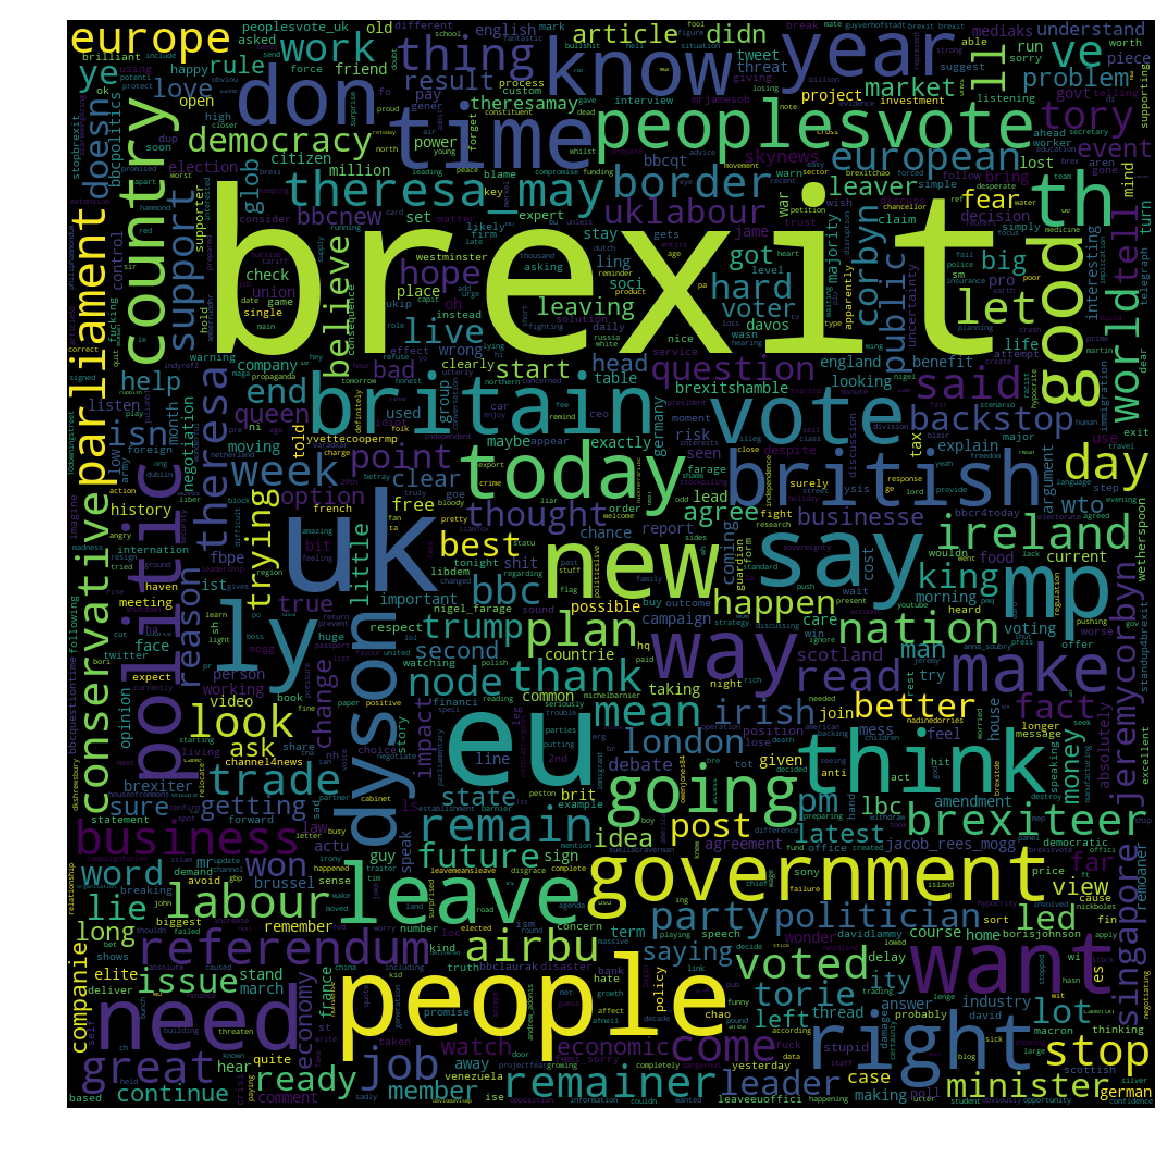

In [39]:
junk = re.compile("al|RT|\n|&.*?;|http[s](?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)*")
tweets = [junk.sub(" ", t) for t in english_df.text]

vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=.5)
tfv = vec.fit_transform(tweets)

terms = vec.get_feature_names()
wc = WordCloud(height=1000, width=1000, max_words=1000).generate(" ".join(terms))

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()